In [2]:
# ============================================
# CONFIGURACIÓN INICIAL
# ============================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Variable objetivo confirmada
TARGET_COLUMN = 'DESEMP_INGLES'

print("✅ Configuración inicial completada")
print(f"✅ Variable objetivo: {TARGET_COLUMN}")

✅ Configuración inicial completada
✅ Variable objetivo: DESEMP_INGLES


In [3]:
# ============================================
# CARGAR DATASET COMPLETO
# ============================================

# IMPORTANTE: Reemplaza 'ruta_a_tu_dataset.csv' con la ruta real
df = pd.read_csv('icfes_results.csv')

print(f"✅ Dataset cargado: {len(df):,} filas × {len(df.columns)} columnas")
print(f"✅ Tamaño en memoria: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

✅ Dataset cargado: 1,087,902 filas × 51 columnas
✅ Tamaño en memoria: 2596.07 MB


In [4]:
# ============================================
# ANÁLISIS DE DESBALANCEO DE CLASES
# ============================================

print("\n" + "=" * 80)
print("ANÁLISIS DE DESBALANCEO DE CLASES")
print("=" * 80)

class_distribution = df[TARGET_COLUMN].value_counts().sort_index()
class_percentage = (class_distribution / len(df) * 100).round(2)

analysis_df = pd.DataFrame({
    'Clase': class_distribution.index,
    'Frecuencia': class_distribution.values,
    'Porcentaje (%)': class_percentage.values,
    'Ratio vs Mayor': (class_distribution.values / class_distribution.max()).round(3)
})

print("\n", analysis_df.to_string(index=False))

# Calcular métricas de desbalanceo
imbalance_ratio = class_distribution.max() / class_distribution.min()
print(f"\n⚠️  Ratio de desbalanceo: {imbalance_ratio:.2f}:1")
print(f"    (Clase mayoritaria / Clase minoritaria)")

if imbalance_ratio > 10:
    print("    ⚠️  ALTO DESBALANCEO - Considerar técnicas de balanceo en Tarea 19")
elif imbalance_ratio > 3:
    print("    ⚠️  DESBALANCEO MODERADO - Recomendable usar técnicas de balanceo")
else:
    print("    ✅ DESBALANCEO ACEPTABLE")


ANÁLISIS DE DESBALANCEO DE CLASES

 Clase  Frecuencia  Porcentaje (%)  Ratio vs Mayor
   A-      538744           49.52           1.000
   A1      306302           28.16           0.569
   A2      158774           14.59           0.295
   B+       14534            1.34           0.027
   B1       69548            6.39           0.129

⚠️  Ratio de desbalanceo: 37.07:1
    (Clase mayoritaria / Clase minoritaria)
    ⚠️  ALTO DESBALANCEO - Considerar técnicas de balanceo en Tarea 19


In [5]:
# ============================================
# DETERMINAR TAMAÑO ÓPTIMO DE LA MUESTRA
# ============================================

print("\n" + "=" * 80)
print("CÁLCULO DEL TAMAÑO ÓPTIMO DE LA MUESTRA")
print("=" * 80)

dataset_size = len(df)
min_samples_per_class = df[TARGET_COLUMN].value_counts().min()

print(f"\n📊 Tamaño del dataset original: {dataset_size:,}")
print(f"📊 Clase minoritaria (B+): {min_samples_per_class:,} observaciones")

# Calcular tamaños sugeridos
suggested_fractions = [0.10, 0.15, 0.20, 0.25, 0.30]
print(f"\n💡 OPCIONES DE TAMAÑO DE MUESTRA:")
print("=" * 80)

for frac in suggested_fractions:
    sample_size = int(dataset_size * frac)
    min_class_in_sample = int(min_samples_per_class * frac)
    
    print(f"  {frac*100:5.0f}% → {sample_size:7,} obs totales | B+ tendría ~{min_class_in_sample:5,} obs", end="")
    
    # Verificar si cumple requisitos mínimos
    if min_class_in_sample < 50:
        print(" ⚠️  (Muy pocos para clase minoritaria)")
    elif min_class_in_sample < 100:
        print(" ⚠️  (Aceptable pero límite)")
    else:
        print(" ✅ (Recomendado)")

# Recomendación automática
if min_samples_per_class * 0.15 >= 100:
    recommended_fraction = 0.15
elif min_samples_per_class * 0.20 >= 100:
    recommended_fraction = 0.20
else:
    recommended_fraction = 0.25

recommended_size = int(dataset_size * recommended_fraction)
print(f"\n✅ TAMAÑO RECOMENDADO: {recommended_fraction*100:.0f}% = {recommended_size:,} observaciones")
print(f"   → Clase minoritaria tendrá ~{int(min_samples_per_class * recommended_fraction):,} observaciones")


CÁLCULO DEL TAMAÑO ÓPTIMO DE LA MUESTRA

📊 Tamaño del dataset original: 1,087,902
📊 Clase minoritaria (B+): 14,534 observaciones

💡 OPCIONES DE TAMAÑO DE MUESTRA:
     10% → 108,790 obs totales | B+ tendría ~1,453 obs ✅ (Recomendado)
     15% → 163,185 obs totales | B+ tendría ~2,180 obs ✅ (Recomendado)
     20% → 217,580 obs totales | B+ tendría ~2,906 obs ✅ (Recomendado)
     25% → 271,975 obs totales | B+ tendría ~3,633 obs ✅ (Recomendado)
     30% → 326,370 obs totales | B+ tendría ~4,360 obs ✅ (Recomendado)

✅ TAMAÑO RECOMENDADO: 15% = 163,185 observaciones
   → Clase minoritaria tendrá ~2,180 observaciones


In [6]:
# ============================================
# FUNCIÓN PARA CREAR MUESTRA ESTRATIFICADA
# ============================================

def create_stratified_sample(data, target_col, sample_fraction=0.20, random_state=42):
    """
    Crea muestra estratificada manteniendo proporción de clases
    
    Parámetros:
    -----------
    data : DataFrame
        Dataset original completo
    target_col : str
        Nombre de la columna objetivo
    sample_fraction : float
        Fracción del dataset a muestrear (0.0 a 1.0)
    random_state : int
        Semilla para reproducibilidad
    
    Retorna:
    --------
    DataFrame : Muestra estratificada
    dict : Información de la muestra
    """
    
    # Validaciones
    if sample_fraction <= 0 or sample_fraction > 1:
        raise ValueError("sample_fraction debe estar entre 0 y 1")
    
    if target_col not in data.columns:
        raise ValueError(f"Columna '{target_col}' no encontrada en el dataset")
    
    # Crear muestra estratificada
    _, sample = train_test_split(
        data,
        test_size=sample_fraction,
        stratify=data[target_col],
        random_state=random_state
    )
    
    # Información de la muestra
    info = {
        'original_size': len(data),
        'sample_size': len(sample),
        'fraction': sample_fraction,
        'random_state': random_state,
        'original_distribution': data[target_col].value_counts().to_dict(),
        'sample_distribution': sample[target_col].value_counts().to_dict()
    }
    
    return sample, info

print("✅ Función create_stratified_sample() definida correctamente")

✅ Función create_stratified_sample() definida correctamente


In [7]:
# ============================================
# GENERAR MUESTRA ESTRATIFICADA
# ============================================

# Parámetros configurables
SAMPLE_FRACTION = 0.20  # Puedes modificar según tu análisis previo
RANDOM_STATE = 42

print("\n" + "=" * 80)
print("GENERANDO MUESTRA ESTRATIFICADA")
print("=" * 80)

print(f"\n⚙️  Parámetros:")
print(f"   - Fracción de muestra: {SAMPLE_FRACTION*100:.1f}%")
print(f"   - Semilla aleatoria: {RANDOM_STATE}")
print(f"   - Variable objetivo: {TARGET_COLUMN}")

# Generar muestra
df_reduced, sample_info = create_stratified_sample(
    data=df,
    target_col=TARGET_COLUMN,
    sample_fraction=SAMPLE_FRACTION,
    random_state=RANDOM_STATE
)

print(f"\n✅ Muestra generada exitosamente")
print(f"   - Dataset original: {sample_info['original_size']:,} observaciones")
print(f"   - Dataset reducido: {sample_info['sample_size']:,} observaciones")
print(f"   - Reducción: {(1 - SAMPLE_FRACTION)*100:.1f}%")


GENERANDO MUESTRA ESTRATIFICADA

⚙️  Parámetros:
   - Fracción de muestra: 20.0%
   - Semilla aleatoria: 42
   - Variable objetivo: DESEMP_INGLES

✅ Muestra generada exitosamente
   - Dataset original: 1,087,902 observaciones
   - Dataset reducido: 217,581 observaciones
   - Reducción: 80.0%


In [8]:
# ============================================
# VERIFICACIÓN DETALLADA DE ESTRATIFICACIÓN
# ============================================

print("\n" + "=" * 80)
print("VERIFICACIÓN DE LA ESTRATIFICACIÓN")
print("=" * 80)

# Crear tabla comparativa detallada
verification_df = pd.DataFrame()

# Distribución original
orig_counts = df[TARGET_COLUMN].value_counts().sort_index()
orig_pcts = (orig_counts / len(df) * 100).round(4)

# Distribución de la muestra
samp_counts = df_reduced[TARGET_COLUMN].value_counts().sort_index()
samp_pcts = (samp_counts / len(df_reduced) * 100).round(4)

# Crear DataFrame comparativo
verification_df['Clase'] = orig_counts.index
verification_df['Original_N'] = orig_counts.values
verification_df['Original_%'] = orig_pcts.values
verification_df['Muestra_N'] = samp_counts.values
verification_df['Muestra_%'] = samp_pcts.values
verification_df['Diff_%'] = (verification_df['Muestra_%'] - verification_df['Original_%']).abs()
verification_df['Ratio_Esperado'] = verification_df['Original_N'] * SAMPLE_FRACTION
verification_df['Ratio_Real'] = verification_df['Muestra_N'] / verification_df['Original_N']

print("\n📊 COMPARACIÓN DETALLADA:")
print(verification_df.to_string(index=False))

# Métricas de calidad de estratificación
max_diff = verification_df['Diff_%'].max()
mean_diff = verification_df['Diff_%'].mean()
std_diff = verification_df['Diff_%'].std()

print(f"\n📈 MÉTRICAS DE CALIDAD:")
print("=" * 80)
print(f"  Diferencia máxima:    {max_diff:.4f}%")
print(f"  Diferencia promedio:  {mean_diff:.4f}%")
print(f"  Desviación estándar:  {std_diff:.4f}%")

# Evaluación de calidad
if max_diff < 0.5:
    print("\n  ✅ EXCELENTE: Estratificación casi perfecta (<0.5% diferencia)")
elif max_diff < 1.0:
    print("\n  ✅ MUY BUENA: Estratificación de alta calidad (<1% diferencia)")
elif max_diff < 2.0:
    print("\n  ✅ BUENA: Estratificación aceptable (<2% diferencia)")
else:
    print("\n  ⚠️  ACEPTABLE: Diferencias tolerables pero revisables")


VERIFICACIÓN DE LA ESTRATIFICACIÓN

📊 COMPARACIÓN DETALLADA:
Clase  Original_N  Original_%  Muestra_N  Muestra_%  Diff_%  Ratio_Esperado  Ratio_Real
   A-      538744     49.5214     107749    49.5213  0.0001        107748.8    0.200000
   A1      306302     28.1553      61260    28.1550  0.0003         61260.4    0.199999
   A2      158774     14.5945      31755    14.5946  0.0001         31754.8    0.200001
   B+       14534      1.3360       2907     1.3361  0.0001          2906.8    0.200014
   B1       69548      6.3929      13910     6.3930  0.0001         13909.6    0.200006

📈 MÉTRICAS DE CALIDAD:
  Diferencia máxima:    0.0003%
  Diferencia promedio:  0.0001%
  Desviación estándar:  0.0001%

  ✅ EXCELENTE: Estratificación casi perfecta (<0.5% diferencia)


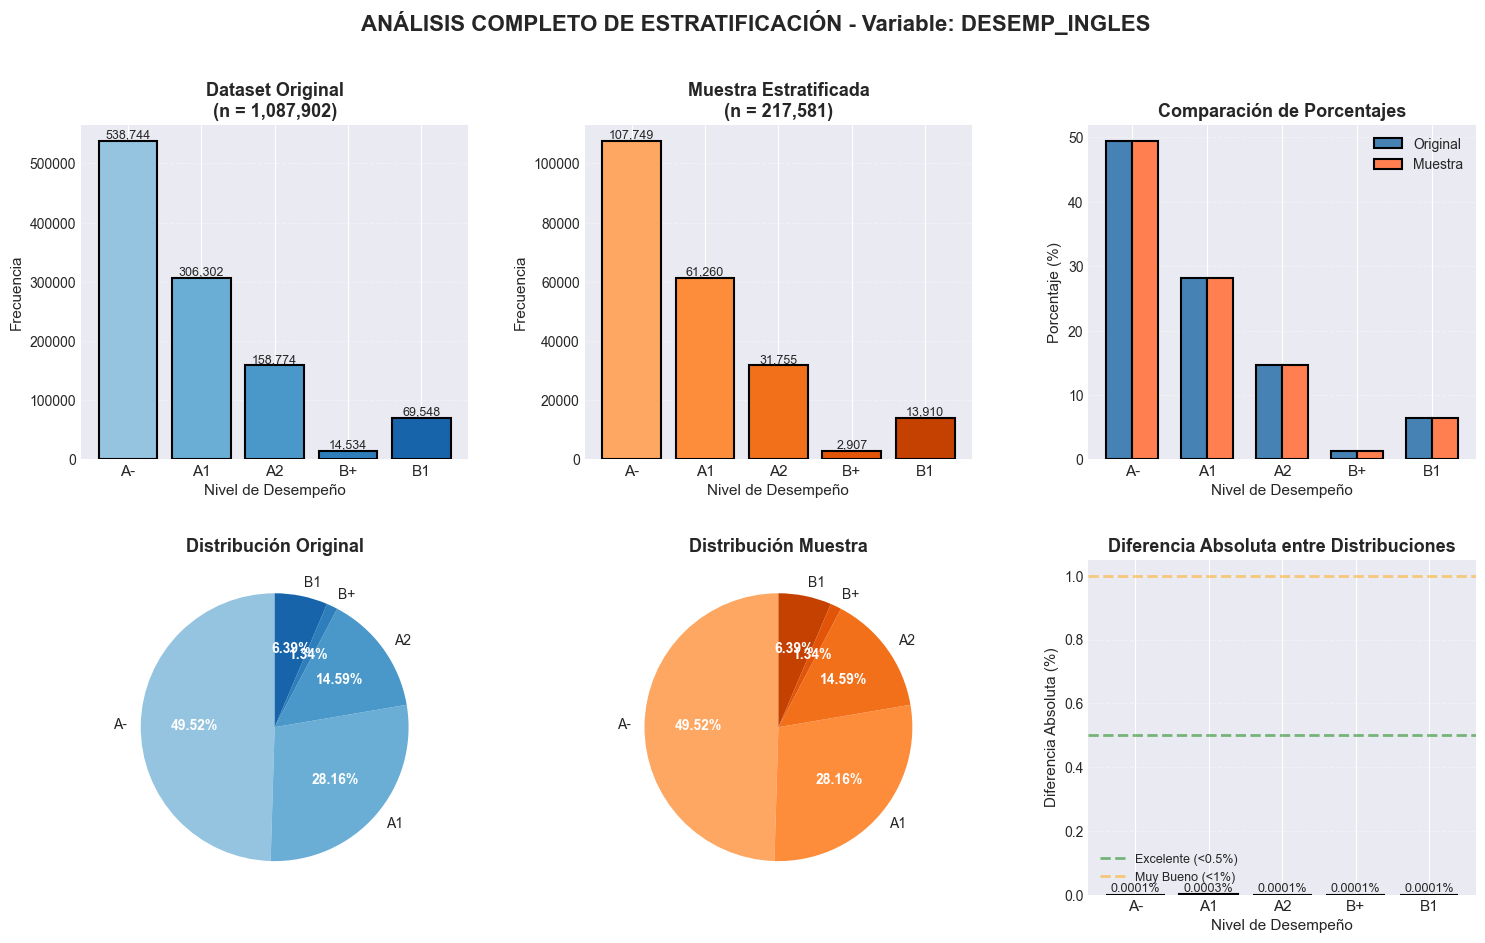


✅ Visualización completa generada


In [9]:
# ============================================
# VISUALIZACIÓN COMPARATIVA COMPLETA
# ============================================

fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# 1. Gráfico de barras - Original
ax1 = fig.add_subplot(gs[0, 0])
colors_orig = plt.cm.Blues(np.linspace(0.4, 0.8, len(orig_counts)))
bars1 = ax1.bar(range(len(orig_counts)), orig_counts.values, color=colors_orig, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(orig_counts)))
ax1.set_xticklabels(orig_counts.index, fontsize=11)
ax1.set_title(f'Dataset Original\n(n = {len(df):,})', fontsize=13, fontweight='bold')
ax1.set_xlabel('Nivel de Desempeño', fontsize=11)
ax1.set_ylabel('Frecuencia', fontsize=11)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 2. Gráfico de barras - Muestra
ax2 = fig.add_subplot(gs[0, 1])
colors_samp = plt.cm.Oranges(np.linspace(0.4, 0.8, len(samp_counts)))
bars2 = ax2.bar(range(len(samp_counts)), samp_counts.values, color=colors_samp, edgecolor='black', linewidth=1.5)
ax2.set_xticks(range(len(samp_counts)))
ax2.set_xticklabels(samp_counts.index, fontsize=11)
ax2.set_title(f'Muestra Estratificada\n(n = {len(df_reduced):,})', fontsize=13, fontweight='bold')
ax2.set_xlabel('Nivel de Desempeño', fontsize=11)
ax2.set_ylabel('Frecuencia', fontsize=11)
ax2.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}', ha='center', va='bottom', fontsize=9)

# 3. Comparación de porcentajes
ax3 = fig.add_subplot(gs[0, 2])
x = np.arange(len(orig_pcts))
width = 0.35
bars3a = ax3.bar(x - width/2, orig_pcts.values, width, label='Original', 
                 color='steelblue', edgecolor='black', linewidth=1.5)
bars3b = ax3.bar(x + width/2, samp_pcts.values, width, label='Muestra', 
                 color='coral', edgecolor='black', linewidth=1.5)
ax3.set_xticks(x)
ax3.set_xticklabels(orig_pcts.index, fontsize=11)
ax3.set_title('Comparación de Porcentajes', fontsize=13, fontweight='bold')
ax3.set_xlabel('Nivel de Desempeño', fontsize=11)
ax3.set_ylabel('Porcentaje (%)', fontsize=11)
ax3.legend(fontsize=10)
ax3.grid(axis='y', alpha=0.3, linestyle='--')

# 4. Gráfico de pastel - Original
ax4 = fig.add_subplot(gs[1, 0])
wedges4, texts4, autotexts4 = ax4.pie(orig_counts.values, labels=orig_counts.index, 
                                        autopct='%1.2f%%', startangle=90, 
                                        colors=colors_orig, textprops={'fontsize': 10})
for autotext in autotexts4:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax4.set_title('Distribución Original', fontsize=13, fontweight='bold')

# 5. Gráfico de pastel - Muestra
ax5 = fig.add_subplot(gs[1, 1])
wedges5, texts5, autotexts5 = ax5.pie(samp_counts.values, labels=samp_counts.index, 
                                        autopct='%1.2f%%', startangle=90, 
                                        colors=colors_samp, textprops={'fontsize': 10})
for autotext in autotexts5:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
ax5.set_title('Distribución Muestra', fontsize=13, fontweight='bold')

# 6. Diferencias absolutas
ax6 = fig.add_subplot(gs[1, 2])
diff_values = verification_df['Diff_%'].values
colors_diff = ['green' if d < 0.5 else 'orange' if d < 1.0 else 'red' for d in diff_values]
bars6 = ax6.bar(range(len(diff_values)), diff_values, color=colors_diff, edgecolor='black', linewidth=1.5)
ax6.set_xticks(range(len(orig_counts)))
ax6.set_xticklabels(orig_counts.index, fontsize=11)
ax6.set_title('Diferencia Absoluta entre Distribuciones', fontsize=13, fontweight='bold')
ax6.set_xlabel('Nivel de Desempeño', fontsize=11)
ax6.set_ylabel('Diferencia Absoluta (%)', fontsize=11)
ax6.axhline(y=0.5, color='green', linestyle='--', linewidth=2, alpha=0.5, label='Excelente (<0.5%)')
ax6.axhline(y=1.0, color='orange', linestyle='--', linewidth=2, alpha=0.5, label='Muy Bueno (<1%)')
ax6.legend(fontsize=9)
ax6.grid(axis='y', alpha=0.3, linestyle='--')
for bar in bars6:
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}%', ha='center', va='bottom', fontsize=9)

plt.suptitle(f'ANÁLISIS COMPLETO DE ESTRATIFICACIÓN - Variable: {TARGET_COLUMN}', 
             fontsize=16, fontweight='bold', y=0.995)
plt.show()

print("\n✅ Visualización completa generada")

In [10]:
# ============================================
# VERIFICAR INTEGRIDAD DE DATOS EN LA MUESTRA
# ============================================

print("\n" + "=" * 80)
print("VERIFICACIÓN DE INTEGRIDAD DE DATOS")
print("=" * 80)

# Contar valores faltantes
missing_original = df.isnull().sum().sum()
missing_sample = df_reduced.isnull().sum().sum()

print(f"\n📊 Valores faltantes:")
print(f"   Original: {missing_original:,} ({missing_original/(df.shape[0]*df.shape[1])*100:.2f}% del total)")
print(f"   Muestra:  {missing_sample:,} ({missing_sample/(df_reduced.shape[0]*df_reduced.shape[1])*100:.2f}% del total)")

# Top columnas con datos faltantes en la muestra
missing_by_column = df_reduced.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_by_column / len(df_reduced) * 100).round(2)

missing_df = pd.DataFrame({
    'Columna': missing_by_column.index,
    'N_Faltantes': missing_by_column.values,
    'Porcentaje': missing_pct.values
}).head(10)

print(f"\n📋 Top 10 columnas con datos faltantes en la muestra:")
print(missing_df.to_string(index=False))

print(f"\n✅ Variable objetivo '{TARGET_COLUMN}' tiene {df_reduced[TARGET_COLUMN].isnull().sum()} valores faltantes")


VERIFICACIÓN DE INTEGRIDAD DE DATOS

📊 Valores faltantes:
   Original: 623,630 (1.12% del total)
   Muestra:  124,370 (1.12% del total)

📋 Top 10 columnas con datos faltantes en la muestra:
             Columna  N_Faltantes  Porcentaje
       COLE_BILINGUE        34707       15.95
FAMI_ESTRATOVIVIENDA        13663        6.28
  FAMI_TIENEINTERNET        12214        5.61
 FAMI_EDUCACIONPADRE        12082        5.55
 FAMI_EDUCACIONMADRE        12004        5.52
 FAMI_TIENEAUTOMOVIL         7101        3.26
   FAMI_CUARTOSHOGAR         6700        3.08
FAMI_TIENECOMPUTADOR         6668        3.06
  FAMI_TIENELAVADORA         6580        3.02
  FAMI_PERSONASHOGAR         6250        2.87

✅ Variable objetivo 'DESEMP_INGLES' tiene 0 valores faltantes


In [11]:
# ============================================
# GUARDAR MUESTRA REDUCIDA
# ============================================

# Nombres de archivos
output_csv = 'dataset_saber11_reducido_estratificado.csv'
output_excel = 'dataset_saber11_reducido_estratificado.xlsx'
output_info = 'dataset_reducido_info.txt'

print("\n" + "=" * 80)
print("GUARDANDO ARCHIVOS")
print("=" * 80)

# 1. Guardar CSV
df_reduced.to_csv(output_csv, index=False, encoding='utf-8')
print(f"\n✅ Archivo CSV guardado: '{output_csv}'")

# 2. Guardar Excel (opcional - comentar si no es necesario)
try:
    df_reduced.to_excel(output_excel, index=False, engine='openpyxl')
    print(f"✅ Archivo Excel guardado: '{output_excel}'")
except:
    print(f"⚠️  No se pudo guardar Excel (openpyxl no instalado o error)")

# 3. Guardar información de la muestra
with open(output_info, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("INFORMACIÓN DEL DATASET REDUCIDO\n")
    f.write("=" * 80 + "\n\n")
    f.write(f"Fecha de generación: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"Variable objetivo: {TARGET_COLUMN}\n")
    f.write(f"Semilla aleatoria: {RANDOM_STATE}\n\n")
    f.write(f"Dataset original:\n")
    f.write(f"  - Observaciones: {sample_info['original_size']:,}\n")
    f.write(f"  - Columnas: {len(df.columns)}\n\n")
    f.write(f"Dataset reducido:\n")
    f.write(f"  - Observaciones: {sample_info['sample_size']:,}\n")
    f.write(f"  - Fracción: {SAMPLE_FRACTION*100:.1f}%\n")
    f.write(f"  - Columnas: {len(df_reduced.columns)}\n\n")
    f.write("Distribución de clases:\n")
    f.write(verification_df.to_string(index=False))
    f.write(f"\n\nMétricas de estratificación:\n")
    f.write(f"  - Diferencia máxima: {max_diff:.4f}%\n")
    f.write(f"  - Diferencia promedio: {mean_diff:.4f}%\n")

print(f"✅ Archivo de información guardado: '{output_info}'")

# Información de tamaño de archivos
import os
csv_size = os.path.getsize(output_csv) / (1024**2)
print(f"\n📦 Tamaño del archivo CSV: {csv_size:.2f} MB")

if os.path.exists(output_excel):
    excel_size = os.path.getsize(output_excel) / (1024**2)
    print(f"📦 Tamaño del archivo Excel: {excel_size:.2f} MB")


GUARDANDO ARCHIVOS

✅ Archivo CSV guardado: 'dataset_saber11_reducido_estratificado.csv'
✅ Archivo Excel guardado: 'dataset_saber11_reducido_estratificado.xlsx'
✅ Archivo de información guardado: 'dataset_reducido_info.txt'

📦 Tamaño del archivo CSV: 88.93 MB
📦 Tamaño del archivo Excel: 54.99 MB


In [12]:
# ============================================
# RESUMEN FINAL
# ============================================

print("\n" + "=" * 80)
print("✅ FASE 1 COMPLETADA EXITOSAMENTE")
print("=" * 80)

print(f"""
📊 RESUMEN DEL PROCESO:

Dataset Original:
  • Observaciones: {len(df):,}
  • Variables: {len(df.columns)}
  • Variable objetivo: {TARGET_COLUMN}
  • Clases: {df[TARGET_COLUMN].nunique()} niveles ({', '.join(sorted(df[TARGET_COLUMN].unique()))})

Dataset Reducido:
  • Observaciones: {len(df_reduced):,}
  • Porcentaje: {SAMPLE_FRACTION*100:.1f}%
  • Estratificación: {max_diff:.4f}% de diferencia máxima

Calidad de Estratificación:
  • Diferencia máxima: {max_diff:.4f}%
  • Diferencia promedio: {mean_diff:.4f}%
  • Evaluación: {'EXCELENTE' if max_diff < 0.5 else 'MUY BUENA' if max_diff < 1.0 else 'BUENA'}

Archivos Generados:
  ✓ {output_csv}
  ✓ {output_info}
  {'✓ ' + output_excel if os.path.exists(output_excel) else ''}

{"=" * 80}
🎯 PRÓXIMO PASO:
{"=" * 80}

El archivo '{output_csv}' está listo para análisis detallado.

Puedes compartir:
1. El archivo CSV completo, o
2. Las primeras 100-200 filas del dataset reducido

Con esto, procederé a desarrollar las 25 tareas completas del proyecto.
""")


✅ FASE 1 COMPLETADA EXITOSAMENTE

📊 RESUMEN DEL PROCESO:

Dataset Original:
  • Observaciones: 1,087,902
  • Variables: 51
  • Variable objetivo: DESEMP_INGLES
  • Clases: 5 niveles (A-, A1, A2, B+, B1)

Dataset Reducido:
  • Observaciones: 217,581
  • Porcentaje: 20.0%
  • Estratificación: 0.0003% de diferencia máxima

Calidad de Estratificación:
  • Diferencia máxima: 0.0003%
  • Diferencia promedio: 0.0001%
  • Evaluación: EXCELENTE

Archivos Generados:
  ✓ dataset_saber11_reducido_estratificado.csv
  ✓ dataset_reducido_info.txt
  ✓ dataset_saber11_reducido_estratificado.xlsx

🎯 PRÓXIMO PASO:

El archivo 'dataset_saber11_reducido_estratificado.csv' está listo para análisis detallado.

Puedes compartir:
1. El archivo CSV completo, o
2. Las primeras 100-200 filas del dataset reducido

Con esto, procederé a desarrollar las 25 tareas completas del proyecto.



GENERANDO VERSIÓN MINI DEL DATASET (1000 FILAS)

⚙️  Parámetros:
   - Dataset reducido actual: 217,581 filas
   - Tamaño objetivo: 1,000 filas
   - Fracción: 0.46%

✅ Versión mini generada: 1,000 filas

📊 VERIFICACIÓN DE DISTRIBUCIÓN EN VERSIÓN MINI:
Clase  Reducido_N  Reducido_%  Mini_N  Mini_%  Diff_%
   A-      107749       49.52     495    49.5    0.02
   A1       61260       28.16     282    28.2    0.04
   A2       31755       14.59     146    14.6    0.01
   B+        2907        1.34      13     1.3    0.04
   B1       13910        6.39      64     6.4    0.01

✅ Diferencia máxima: 0.04%


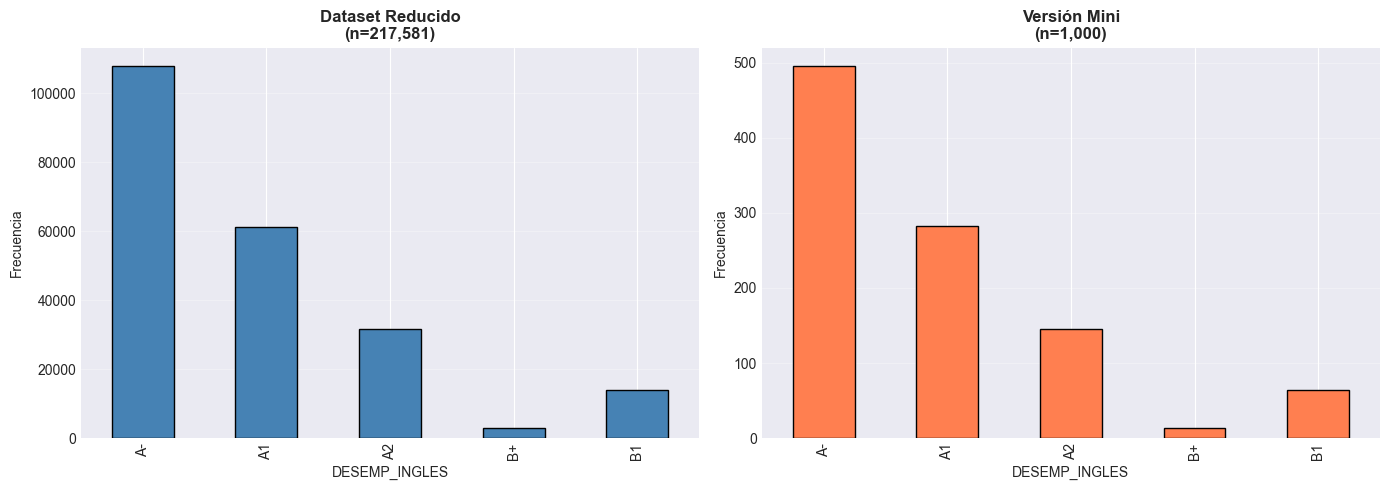


✅ Archivo guardado: 'dataset_saber11_MINI_1000filas.csv'
📦 Tamaño: 0.41 MB
📊 Filas: 1,000
📊 Columnas: 51

✅ VERSIÓN MINI LISTA PARA COMPARTIR

Comparte el archivo 'dataset_saber11_MINI_1000filas.csv' para análisis detallado
Este archivo es 0.4 MB y tiene 1,000 observaciones estratificadas


In [13]:
# ============================================
# GENERAR VERSIÓN MINI PARA ANÁLISIS (1000 FILAS)
# ============================================

print("=" * 80)
print("GENERANDO VERSIÓN MINI DEL DATASET (1000 FILAS)")
print("=" * 80)

# Número de filas para la versión mini
N_ROWS_MINI = 1000

# Calcular la fracción necesaria
mini_fraction = N_ROWS_MINI / len(df_reduced)

print(f"\n⚙️  Parámetros:")
print(f"   - Dataset reducido actual: {len(df_reduced):,} filas")
print(f"   - Tamaño objetivo: {N_ROWS_MINI:,} filas")
print(f"   - Fracción: {mini_fraction*100:.2f}%")

# Crear versión mini estratificada
df_mini = create_stratified_sample(
    data=df_reduced,
    target_col=TARGET_COLUMN,
    sample_fraction=mini_fraction,
    random_state=RANDOM_STATE
)[0]

print(f"\n✅ Versión mini generada: {len(df_mini):,} filas")

# Verificar distribución
print("\n📊 VERIFICACIÓN DE DISTRIBUCIÓN EN VERSIÓN MINI:")
print("=" * 80)

comparison_mini = pd.DataFrame({
    'Clase': df_reduced[TARGET_COLUMN].value_counts().sort_index().index,
    'Reducido_N': df_reduced[TARGET_COLUMN].value_counts().sort_index().values,
    'Reducido_%': (df_reduced[TARGET_COLUMN].value_counts(normalize=True) * 100).sort_index().round(2).values,
    'Mini_N': df_mini[TARGET_COLUMN].value_counts().sort_index().values,
    'Mini_%': (df_mini[TARGET_COLUMN].value_counts(normalize=True) * 100).sort_index().round(2).values,
})

comparison_mini['Diff_%'] = (comparison_mini['Mini_%'] - comparison_mini['Reducido_%']).abs()

print(comparison_mini.to_string(index=False))

max_diff_mini = comparison_mini['Diff_%'].max()
print(f"\n✅ Diferencia máxima: {max_diff_mini:.2f}%")

# Visualización rápida
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Reducido
df_reduced[TARGET_COLUMN].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='steelblue', edgecolor='black'
)
axes[0].set_title(f'Dataset Reducido\n(n={len(df_reduced):,})', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frecuencia')
axes[0].grid(axis='y', alpha=0.3)

# Mini
df_mini[TARGET_COLUMN].value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color='coral', edgecolor='black'
)
axes[1].set_title(f'Versión Mini\n(n={len(df_mini):,})', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frecuencia')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Guardar versión mini
output_mini = 'dataset_saber11_MINI_1000filas.csv'
df_mini.to_csv(output_mini, index=False, encoding='utf-8')

import os
mini_size = os.path.getsize(output_mini) / (1024**2)

print(f"\n✅ Archivo guardado: '{output_mini}'")
print(f"📦 Tamaño: {mini_size:.2f} MB")
print(f"📊 Filas: {len(df_mini):,}")
print(f"📊 Columnas: {len(df_mini.columns)}")

print("\n" + "=" * 80)
print("✅ VERSIÓN MINI LISTA PARA COMPARTIR")
print("=" * 80)
print(f"\nComparte el archivo '{output_mini}' para análisis detallado")
print(f"Este archivo es {mini_size:.1f} MB y tiene {len(df_mini):,} observaciones estratificadas")